In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import json

sys.path.insert(0, "./../")
from FileManager import FileManager
from ExptTrace import ExptTrace
import utils
utils.rcsetup()

In [2]:
sgns_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "ablation-sgns")
quartic_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "ablation-quartic")
omn_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "ablation-omn")
qwem_dir = os.path.join(os.getenv("EXPTPATH"), "qwem", "ablation-qwem")

def get_results(dir):
    fm = FileManager(dir)
    results = fm.load("results.pickle")
    with open(fm.get_filename("hypers.json")) as f:
        hypers = json.load(f)
    return hypers, *[ExptTrace.deserialize(x) for x in results]

_, _, _, et_sv_sgns = get_results(sgns_dir)
sgns_sv_t = np.array(et_sv_sgns[:])

_, _, _, et_sv_quartic = get_results(quartic_dir)
quartic_sv_t = np.array(et_sv_quartic[:])

_, _, _, et_sv_omn = get_results(omn_dir)
omn_sv_t = np.array(et_sv_omn[:])

H, _, _, et_sv_qwem = get_results(qwem_dir)
qwem_sv_t = np.array(et_sv_qwem[:])

VOCAB_SZ = H["vocab_sz"]
CONTEXT_LEN = H["context_len"]
LR = H["lr"]
EMBEDDIM = H["embeddim"]

In [3]:
data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("cocanow")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

data_fm.set_filepath(f"cocanow/REC-eigh-V{VOCAB_SZ//1000}k")
eigvecs = data_fm.load("eigvecs.npy")
eigvals = data_fm.load("eigvals.npy")
data_fm.set_filepath(f"cocanow")
if eigvecs is None or eigvals is None:
    raise FileNotFoundError("Run mstar_eigh.ipynb first.")
W_Mstar = eigvecs[:, :EMBEDDIM] @ np.diag(eigvals[:EMBEDDIM])

In [4]:
def get_min_loss():
    corpus_stats = data_fm.load("corpus_stats.pickle")
    cL = corpus_stats["context_len"]
    Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
    numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
    Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
    PiPj = np.outer(unigram, unigram)
    Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
    min_loss = -1 * (Mstar**2).mean()
    return min_loss

min_loss = get_min_loss()

In [ ]:
def get_tchar(lambda_init, lr, min_loss):
    lambda_max = np.max(eigvals)
    lr_eff = (-1/min_loss) * lr * 4 / (VOCAB_SZ**2)
    tscale = (1/lambda_max) * np.log(lambda_max/lambda_init)
    tchar = tscale / lr_eff
    return tscale, tchar


lambda_init = H["init_sz"]**2
lr = H["lr"]
tscale, tchar = get_tchar(lambda_init, lr, min_loss)
sgns_tt = np.array(et_sv_sgns.get_axis("nstep"), dtype=np.float32) / tchar * 10
quartic_tt = np.array(et_sv_quartic.get_axis("nstep"), dtype=np.float32) / tchar * 10
omn_tt = np.array(et_sv_omn.get_axis("nstep"), dtype=np.float32) / tchar
qwem_tt = np.array(et_sv_qwem.get_axis("nstep"), dtype=np.float32) / tchar

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


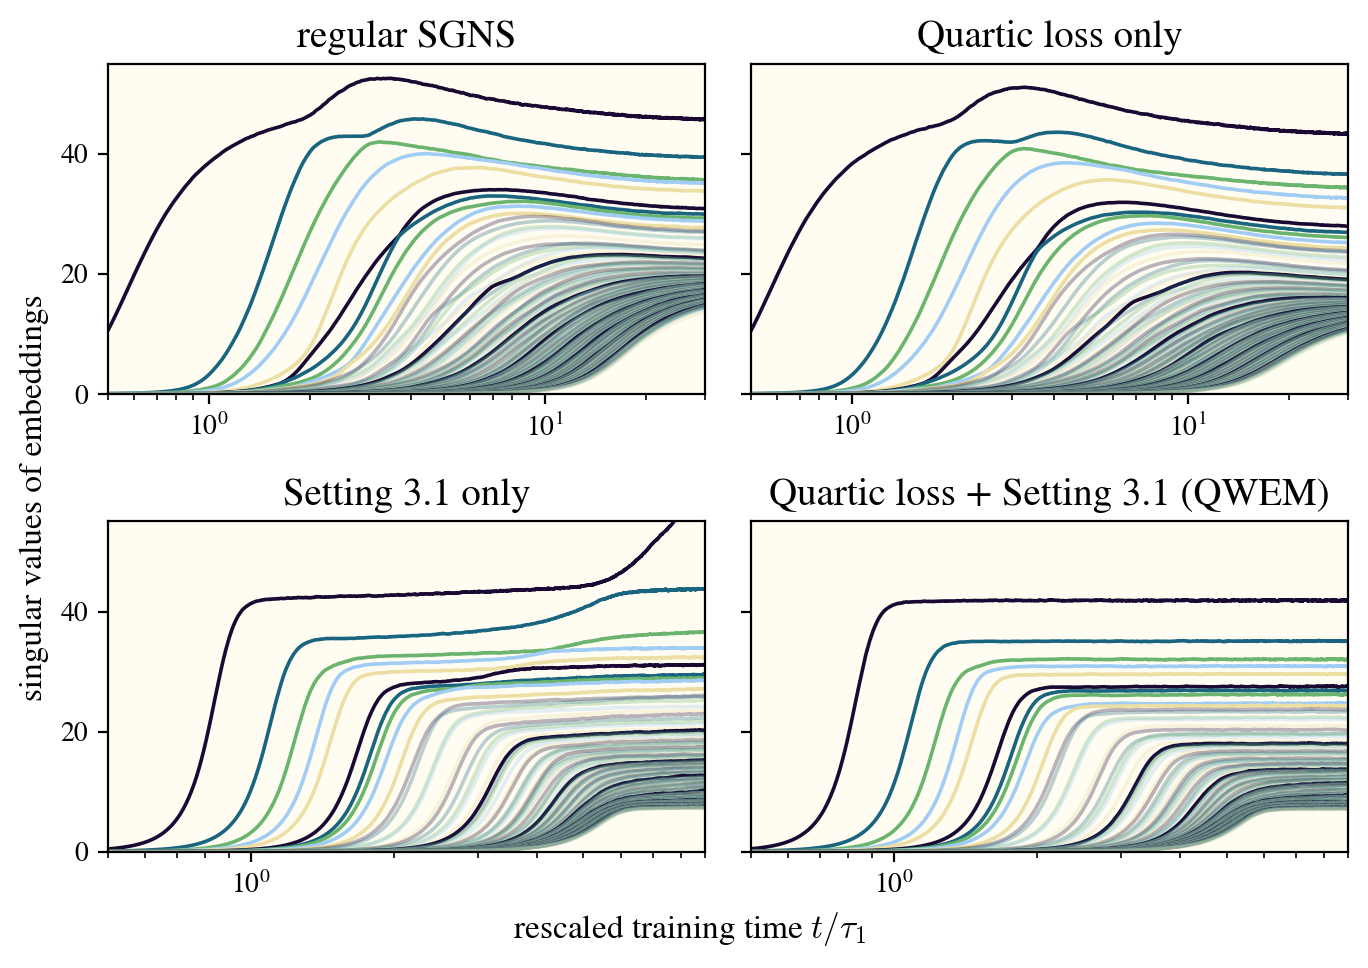

In [25]:
results = [
    [sgns_tt, sgns_sv_t], [quartic_tt, quartic_sv_t],
    [omn_tt, omn_sv_t], [qwem_tt, qwem_sv_t],
]

def get_sv_color(j, scheme=0):
    colors = [
        "#002676 #76641C #D68C1D #F0B811 #FFCD50".split(" "),
        "#190933 #19647E #6BB46D #A1CDF4 #EDDEA4".split(' ')
    ]
    colors = colors[scheme]
    color = colors[j%5]
    if j < 10:
        alpha = 1
    elif j%20 == 0:
        alpha = 1
    else:
        alpha=0.3
    return color, alpha

fig, axes = plt.subplots(2, 2, figsize=(7, 5), dpi=200)
axes = axes.flat

titles = [
    "regular SGNS", "Quartic loss only",
    "Setting 3.1 only", "Quartic loss + Setting 3.1 (QWEM)"
]
for i, ax in enumerate(axes):
    tt, sv_t = results[i]
    ax.set_xlim(.5, 9)
    if i in [1, 3]:
        ax.tick_params(axis='y', labelleft=False)
    if i in [2]:
        ax.set_ylabel(" "*45 + "singular values of embeddings")
        ax.set_xlabel(" "*68 + r"rescaled training time $t/\tau_1$")
    if i in [0, 1]:
        ax.set_xlim(.5, 30)
    
    for j, svs in enumerate(sv_t.T):
        color, alpha = get_sv_color(j, scheme=1)
        ax.plot(tt, svs, color=color, alpha=alpha, lw=1.3, zorder=-3)
    
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xscale('log')
    ax.set_ylim(0, 55)
    ax.set_title(titles[i], fontsize=14)

plt.tight_layout()
plt.savefig('./figures/appx-ablation.pdf', format='pdf', bbox_inches='tight')
# plt.show()